In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

In [ ]:
import time
time.sleep(5)

# Segmentation

--------------

## Separating an image into one or more regions of interest.

Everyone has heard or seen Photoshop or a similar graphics editor take a person from one image and place them into another.  The first step of doing this is *identifying where that person is in the source image*.

In popular culture, the Terminator's vision segments humans out of the overall scene:

<img src="../images/terminator-vision.png" width="700px"/>

Segmentation is a fundamental operation in scientific image analysis because we often want to measure properties of real, physical *objects* such as cells embedded in our image. As such, we want to find those objects within our image.

Computationally, segmentations are most often represented as images, of the same size as the original image, containing integer *labels*, with one value representing one object.

Here is a very simple image and segmentation, taken from [this scikit-image tutorial](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html#sphx-glr-auto-examples-segmentation-plot-watershed-py):

In [2]:
import numpy as np
from scipy import ndimage as ndi

import napari

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

viewer = napari.Viewer()
image_layer = viewer.add_image(image)
labels_layer = viewer.add_labels(labels)
labels_as_image_layer = viewer.add_image(
    labels, name='labels as image'
)

In [4]:
viewer.window.activate()

In [3]:
import sys
print(sys.executable)

/Users/jni/conda/envs/i2k/bin/python


Notice that "labels" is just a NumPy array with integer values. We have to be careful to interpret it as labels and not as an image.

## Segmenting nuclei and measuring cell properties

In the rest of this notebook, we will segment nuclei from a small sample image provided by the Allen Institute for Cell Science.

In [5]:
import tifffile


nuclei = tifffile.imread('../images/cells.tif')
membranes = tifffile.imread('../images/cells_membrane.tif')

print("shape: {}".format(nuclei.shape))
print("dtype: {}".format(nuclei.dtype))
print("range: ({}, {})".format(np.min(nuclei), np.max(nuclei)))

shape: (60, 256, 256)
dtype: float64
range: (0.0, 1.0)


The pixel spacing in this dataset is 0.29µm in the z (leading!) axis, and 0.26µm in the x and y axes.

In [6]:
spacing = np.array([0.29, 0.26, 0.26])

We can view the 3D image using napari.

In [7]:
viewer = napari.view_image(
    nuclei,
    contrast_limits=[0, 1],
    scale=spacing,
    ndisplay=3,
)

In [ ]:
from napari.utils.notebook_display import nbscreenshot

viewer.dims.ndisplay = 3
viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer)

## Edge detection

We saw the [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) in the filters lesson. It is an edge detection algorithm that approximates the gradient of the image intensity, and is fast to compute. The [Scharr filter](https://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.scharr) is a slightly more sophisticated version, with smoothing weights [3, 10, 3]. Both work for n-dimensional images in scikit-image.

In [8]:
from skimage import filters


edges = filters.scharr(nuclei)

nuclei_layer = viewer.layers['nuclei']
nuclei_layer.blending = 'additive'
nuclei_layer.colormap = 'green'

viewer.add_image(
    edges,
    scale=spacing,
    blending='additive',
    colormap='magenta',
)

<Image layer 'edges' at 0x7fd1c9a9f820>

In [ ]:
nbscreenshot(viewer)

## Thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. In many cases, images can be adequately segmented by thresholding followed by labelling of *connected components*, which is a fancy way of saying "groups of pixels that touch each other".

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.

In [9]:
denoised = ndi.median_filter(nuclei, size=3)

In [10]:
li_thresholded = denoised > filters.threshold_li(denoised)

In [11]:
viewer.add_image(
    li_thresholded,
    scale=spacing,
    opacity=0.3,
)

<Image layer 'li_thresholded' at 0x7fd1be75e550>

In [ ]:
nbscreenshot(viewer)

## Morphological operations

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a size parameter, which is the minimum size (in pixels) of accepted holes or objects. It's useful in 3D to think in linear dimensions, then cube them. In this case, we remove holes / objects of the same size as a cube 20 pixels across.

In [12]:
from skimage import morphology

In [13]:
width = 20

remove_holes = morphology.remove_small_holes(
    li_thresholded, width ** 3
)

In [14]:
width = 20

remove_objects = morphology.remove_small_objects(
    remove_holes, width ** 3
)

viewer.add_image(
    remove_objects,
    name='cleaned',
    scale=spacing,
    opacity=0.3,
);

viewer.layers['li_thresholded'].visible = False

In [ ]:
nbscreenshot(viewer)

## Segmentation

Now we are ready to label the connected components of this image.

In [15]:
from skimage import measure

labels = measure.label(remove_objects)

viewer.add_labels(
    labels,
    scale=spacing,
    opacity=0.5,
)

viewer.layers['cleaned'].visible = False

In [ ]:
nbscreenshot(viewer)

We can see that tightly packed cells connected in the binary image are assigned the same label.

A better segmentation would assign different labels to different nuclei. 

Typically we use [watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) for this purpose. We place *markers* at the centre of each object, and these labels are expanded until they meet an edge or an adjacent marker.

The trick, then, is how to find these markers. It can be quite challenging to find markers with the right location. A slight amount of noise in the image can result in very wrong point locations. Here is a common approach: find the distance from the object boundaries, then place points at the maximal distance.

In [16]:
transformed = ndi.distance_transform_edt(remove_objects, sampling=spacing)

maxima = morphology.local_maxima(transformed)

viewer.add_points(
    np.transpose(np.nonzero(maxima)),
    name='bad points',
    scale=spacing,
    size=4,
    n_dimensional=True,  # points have 3D "extent"
)

<Points layer 'bad points' at 0x7fd1d15385b0>

In [ ]:
nbscreenshot(viewer)

You can see that these points are actually terrible, with many markers found within each nuclei.

### <span style="color:cornflowerblue">Exercise: improve the points</span>

Try to improve the segmentation to assign one point for each nucleus. Some ideas:

- use a smoothed version of the nuclei image directly
- smooth the distance map
- use morphological operations to smooth the surface of the nuclei to ensure that they are close to spherical
- use peak_local_max with `min_distance` parameter instead of `morphology.local_maxima`
- find points on a single plane, then prepend the plane index to the found coordinates

In [17]:
from skimage import feature

maxima2 = feature.peak_local_max(
    transformed,
    indices=False,
    min_distance=15,
    threshold_abs=0.0001,
    threshold_rel=0.0001,
    exclude_border=False,
)

viewer.add_points(
    np.transpose(np.nonzero(maxima2)),
    name='better points',
    scale=spacing,
    size=4,
    n_dimensional=True,  # points have 3D "extent"
)

<Points layer 'better points' at 0x7fd1b9373760>

In [18]:
proofread_points = viewer.layers['better points'].data

In [19]:
print(proofread_points)

[[ 32 205 169]
 [ 32 251 197]
 [ 33 219 248]
 [ 34  98 255]
 [ 34 185  45]
 [ 34 217  81]
 [ 34 233 126]
 [ 35  47 229]
 [ 35  67 110]
 [ 35 147 191]
 [ 35 147 245]
 [ 35 156 107]
 [ 36  12  19]
 [ 36  13 153]
 [ 36  36  72]
 [ 36  46 183]
 [ 36  99 160]
 [ 38  76  60]
 [ 39 141  39]]


As you will have seen from the previous exercise, there are many approaches to find better seed points, but they are often fiddly and tedious, and sensitive to parameters — when you encounter a new image, you might have to start all over again!

With napari, in many cases, a little interactivity, combined with the segmentation algorithms in scikit-image and elsewhere, can quickly get us the segmentation we want.

Below, you can use full manual annotation, or light editing of the points you found automatically.

In [ ]:
viewer.layers['bad points'].visible = False
viewer.dims.ndisplay = 2
viewer.dims.set_point(0, 30 * spacing[0])

points = viewer.add_points(
    name='interactive points',
    scale=spacing,
    ndim=3,
    size=4,
    n_dimensional=True,
)
points.mode = 'add'


# now, we annotate the centers of the nuclei in your image

In [ ]:
viewer.dims.ndisplay = 3
viewer.camera.angles = (-30, 25, 120)
nbscreenshot(viewer)

In [ ]:
# unscaled points.data
# this cell is only to simulate interactive annotation,
# no need to run it if you already have annotations.


points.data = np.array(
      [[ 30.        ,  14.2598685 ,  27.7741219 ],
       [ 30.        ,  30.10416663,  81.36513029],
       [ 30.        ,  13.32785096, 144.27631406],
       [ 30.        ,  46.8804823 , 191.80920846],
       [ 30.        ,  43.15241215, 211.84758551],
       [ 30.        ,  94.87938547, 160.12061219],
       [ 30.        ,  72.97697335, 112.58771779],
       [ 30.        , 138.21820096, 189.01315585],
       [ 30.        , 144.74232372, 242.60416424],
       [ 30.        ,  98.14144685, 251.92433962],
       [ 30.        , 153.59649032, 112.58771779],
       [ 30.        , 134.49013081,  40.35635865],
       [ 30.        , 182.95504275,  48.74451649],
       [ 30.        , 216.04166532,  80.89912152],
       [ 30.        , 235.14802483, 130.296051  ],
       [ 30.        , 196.00328827, 169.44078757],
       [ 30.        , 245.86622651, 202.06140137],
       [ 30.        , 213.71162148, 250.52631331],
       [ 28.        ,  87.42324517,  52.00657787]],
      dtype=float,
)

Once you have marked all the points, you can grab the data back, and make a markers image for `skimage.segmentation.watershed`:

In [20]:
from skimage import segmentation

marker_locations = proofread_points

markers = np.zeros(nuclei.shape, dtype=np.uint32)
marker_indices = tuple(np.round(marker_locations).astype(int).T)
markers[marker_indices] = np.arange(len(marker_locations)) + 1
markers_big = morphology.dilation(markers, morphology.ball(5))

segmented = segmentation.watershed(
    edges,
    markers_big,
    mask=remove_objects,
)

viewer.add_labels(
    segmented,
    scale=spacing,
)

viewer.layers['labels'].visible = False

In [ ]:
nbscreenshot(viewer)

After watershed, we have better disambiguation between internal cells!

## Making measurements

Once we have defined our objects, we can make measurements on them using `skimage.measure.regionprops` and the new `skimage.measure.regionprops_table`. These measurements include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

Given the layer-like structure of our data, we only want to clear the objects touching the sides of the volume, but not the top and bottom, so we pad and crop the volume along the 0th axis to avoid clearing the mitotic nucleus.

In [21]:
segmented_padded = np.pad(
    segmented,
    ((1, 1), (0, 0), (0, 0)),
    mode='constant',
    constant_values=0,
)

In [22]:
interior_labels = segmentation.clear_border(segmented_padded)[1:-1]

In [24]:
viewer.add_labels(
    interior_labels,
    scale=spacing,
)

<Labels layer 'interior_labels' at 0x7fd19a0e7430>

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below we build a list of supported and unsupported 3D measurements.

In [25]:
regionprops = measure.regionprops(interior_labels, intensity_image=nuclei)

supported = [] 
unsupported = []

for prop in regionprops[0]:
    try:
        regionprops[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties:")
print("  " + "\n  ".join(supported))
print()
print("Unsupported properties:")
print("  " + "\n  ".join(unsupported))

Supported properties:
  area
  bbox
  bbox_area
  centroid
  convex_area
  convex_image
  coords
  equivalent_diameter
  euler_number
  extent
  filled_area
  filled_image
  image
  inertia_tensor
  inertia_tensor_eigvals
  intensity_image
  label
  local_centroid
  major_axis_length
  max_intensity
  mean_intensity
  min_intensity
  minor_axis_length
  moments
  moments_central
  moments_normalized
  slice
  solidity
  weighted_centroid
  weighted_local_centroid
  weighted_moments
  weighted_moments_central
  weighted_moments_normalized

Unsupported properties:
  eccentricity
  moments_hu
  orientation
  perimeter
  weighted_moments_hu


scikit-image 0.18 adds support for [passing custom functions](https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) for region properties as `extra_properties`. After this tutorial, you might want to try it out to [determine the surface area](https://github.com/scikit-image/scikit-image/issues/3797#issuecomment-471277056) of the nuclei or cells!

`skimage.measure.regionprops` ignores the 0 label, which represents the background.

`regionprops_table` returns a dictionary of columns compatible with creating a pandas dataframe of properties of the data:

In [26]:
import pandas as pd


info_table = pd.DataFrame(
    measure.regionprops_table(
        interior_labels,
        intensity_image=nuclei,
        properties=['label', 'slice', 'area', 'mean_intensity', 'solidity'],
    )
).set_index('label')

In [27]:
info_table.head()

,slice,area,mean_intensity,solidity
label,,,,
1,"(slice(19, 50, None), slice(176, 228, None), s...",48979,0.231506,0.901310
5,"(slice(19, 52, None), slice(158, 209, None), s...",40226,0.198043,0.904423
6,"(slice(17, 53, None), slice(192, 252, None), s...",58046,0.213391,0.905300
8,"(slice(20, 52, None), slice(23, 75, None), sli...",36993,0.181161,0.913002
9,"(slice(19, 51, None), slice(47, 99, None), sli...",40504,0.185613,0.911985


We can now use pandas and seaborn for some analysis!

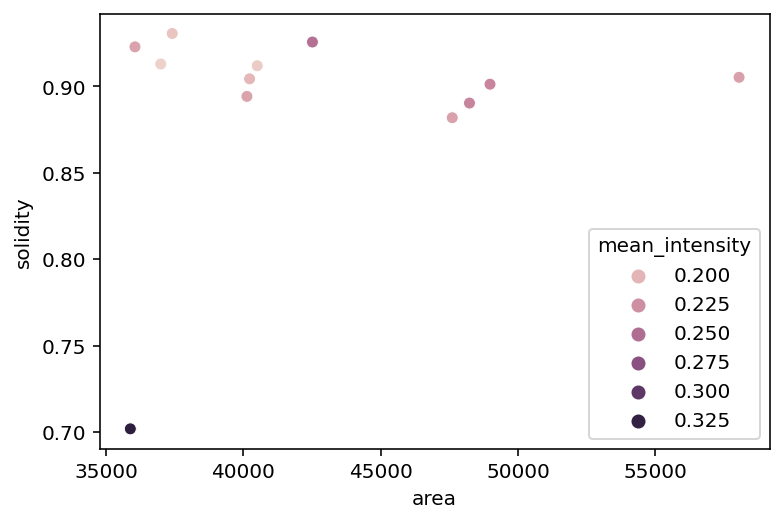

In [28]:
import seaborn as sns

sns.scatterplot(x='area', y='solidity', data=info_table, hue='mean_intensity');

We can see that the mitotic nucleus is a clear outlier from the others in terms of solidity and intensity.

### <span style="color:cornflowerblue">Exercise: physical measurements</span>

The "area" property above is actually the volume of the region, measured in voxels. Add a new column to your dataframe, `'area_um3'`, containing the volume in µm&sup3;.

In [29]:
info_table.columns

Index(['slice', 'area', 'mean_intensity', 'solidity'], dtype='object')

In [31]:
info_table['area_um3'] = info_table['area'] * np.product(spacing)

In [32]:
info_table.head()

,slice,area,mean_intensity,solidity,area_um3
label,,,,,
1,"(slice(19, 50, None), slice(176, 228, None), s...",48979,0.231506,0.901310,960.184316
5,"(slice(19, 52, None), slice(158, 209, None), s...",40226,0.198043,0.904423,788.590504
6,"(slice(17, 53, None), slice(192, 252, None), s...",58046,0.213391,0.905300,1137.933784
8,"(slice(20, 52, None), slice(23, 75, None), sli...",36993,0.181161,0.913002,725.210772
9,"(slice(19, 51, None), slice(47, 99, None), sli...",40504,0.185613,0.911985,794.040416


In [ ]:
info_table['area_um3'] = info_table['area'] * np.product

### <span style="color:cornflowerblue">Exercise: full cell segmentation</span>

Above, we loaded the membranes image into memory, but we have yet to use it.

- Add the membranes to the image.
- Use watershed to segment the full cells, and add the segmentation to the display

### <span style="color:cornflowerblue">Exercise: displaying regionprops (or other values)</span>

Now that you have segmented cells, (or even with just the nuclei), use [`skimage.util.map_array`](https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.map_array) to display a volume of the value of a regionprop (say, 'solidity' of the cells) on top of the segments.